In [1]:
from __future__ import annotations

import datetime
from typing import List, Dict, Tuple

import numpy as np
import matplotlib.pyplot as plt
import sentence_transformers

import toolpy as tp
import cst_python as cst
from toolpy.tool.tool import TextLike
from toolpy.integrations import groq

In [2]:
groq_interface = groq.GroqInterface(model=groq.GroqModel.LLAMA3_70B, n_retry=5)

registry = tp.llm.LLMRegistry()
registry.registry(model_name="llama3-70b", interface=groq_interface, default=True)

In [3]:
input_memories  = [
  {
    "index": "0",
    "type": "event",
    "created": "2024-06-01 08:00:00",
    "description": "Alex attended a nature photography workshop in the city park.",
  },
  {
    "index": "1",
    "type": "thought",
    "created": "2024-06-01 19:00:00",
    "description": "Reflecting on the new techniques learned during the workshop, considering how to apply them in future projects.",
  },
  {
    "index": "2",
    "type": "event",
    "created": "2024-06-05 10:00:00",
    "description": "Alex completed a major software development project at work, delivering the final product to the client.",
  },
  {
    "index": "3",
    "type": "thought",
    "created": "2024-06-05 20:00:00",
    "description": "After delivering the project, Alex felt a sense of relief and accomplishment, thinking about the challenges overcome.",
  },
  {
    "index": "4",
    "type": "event",
    "created": "2024-06-10 16:00:00",
    "description": "Alex went on a weekend trip to explore a national park, taking photos of the wildlife and landscapes.",
  }
]

In [102]:
for m in input_memories:
    m["last_acessed"] = datetime.datetime.fromisoformat(m["created"]).timestamp()


In [4]:
class Embedder(tp.Tool):
    _description = "Creates text embeddings"
    _input_description = {"texts":"list of texts to embed"}
    _return_description = {"embeddings":"list of generated embeddings"}

    def __init__(self, embedder_model: str | None = None) -> None:
        super().__init__(self._description, self._input_description)

        if embedder_model is None:
            embedder_model = "all-MiniLM-L6-v2"

        self._embedder = sentence_transformers.SentenceTransformer(embedder_model)
    
    def _execute(self, query: Dict[str, str] | None, context: str | None) -> Tuple[Dict[str, TextLike], Dict[str, str]]:
        texts = query["texts"]
        embeddings = self._embedder.encode(texts)

        result = {"embeddings":embeddings}

        return result, self._return_description

In [5]:
embedder = Embedder()

In [6]:
result, _ = embedder({"texts":[m["description"] for m in input_memories]})

In [7]:
input_memories

[{'index': '0',
  'type': 'event',
  'created': '2024-06-01 08:00:00',
  'description': 'Alex attended a nature photography workshop in the city park.'},
 {'index': '1',
  'type': 'thought',
  'created': '2024-06-01 19:00:00',
  'description': 'Reflecting on the new techniques learned during the workshop, considering how to apply them in future projects.'},
 {'index': '2',
  'type': 'event',
  'created': '2024-06-05 10:00:00',
  'description': 'Alex completed a major software development project at work, delivering the final product to the client.'},
 {'index': '3',
  'type': 'thought',
  'created': '2024-06-05 20:00:00',
  'description': 'After delivering the project, Alex felt a sense of relief and accomplishment, thinking about the challenges overcome.'},
 {'index': '4',
  'type': 'event',
  'created': '2024-06-10 16:00:00',
  'description': 'Alex went on a weekend trip to explore a national park, taking photos of the wildlife and landscapes.'}]

In [8]:
memories = []

for i in range(len(input_memories)):
    memories.append(input_memories[i].copy())
    memories[i]["embedding"] = result["embeddings"][i]

## Tools

In [9]:
from typing import Dict, Tuple


class MemoryImportanceScorer(tp.BasicTool):
    _description = "Evaluates the intrinsic importance of a memory, distinguishing between core memories and mundane memories"
    _input_description = {"memory":"the memory description"}

    _system_message = '''You are a memory importance scorer that outputs in JSON.
The JSON must use the schema: {'score':'float'}. 

Please use a valid JSON format.'''

    _base_prompt = '''On the scale of 1 to 10, where 1 is purely mundane (e.g., brushing teeth, making bed) and 10 is extremely poignant (e.g., a break up, college acceptance), rate the likely poignancy of the following piece of memory.

Memory: {memory}'''

    _return_description = {'score':'the importance score for the memory'}

    def __init__(self, model_name: str | None = None) -> None:
        super().__init__(description=self._description, 
                         input_description=self._input_description, 
                         prompt_template=self._base_prompt, 
                         return_description=self._return_description, 
                         system_message=self._system_message,
                         model_name=model_name,
                         json_mode=True)
        
    def _execute(self, query: Dict[str, str], context: str) -> Tuple[Dict[str, TextLike], Dict[str, str]]:
        result, return_description =  super()._execute(query, context)
        
        score = result["score"]
        norm_score = (score-1)/9
        result["score"] = norm_score
    
        return result, return_description
        

In [10]:
importance_scorer = MemoryImportanceScorer()

In [11]:
scores = []

for memory in memories:
    result, _ = importance_scorer({"memory":memory["description"]})
    
    memory["importance"] = result["score"]

In [15]:
[m["importance"] for m in memories]

[0.16666666666666666,
 0.2777777777777778,
 0.6888888888888889,
 0.6111111111111112,
 0.6111111111111112]

In [37]:
class MemoryRelevanceScorer(tp.Tool):
    _description = "Scores the contextual relevance of memories"
    _input_description = {"query_memory":"single memory defining the context", "embeddings":"list of memories embeddings"}
    _return_description = {"scores":"list of generated scores"}

    def __init__(self, embedder_model: str | None = None) -> None:
        super().__init__(self._description, self._input_description)

        if embedder_model is None:
            embedder_model = "all-MiniLM-L6-v2"

        self._embedder = sentence_transformers.SentenceTransformer(embedder_model)
    
    def _execute(self, query: Dict[str, str] | None, context: str | None) -> Tuple[Dict[str, TextLike], Dict[str, str]]:
        query_memory = query["query_memory"]
        embeddings = query["embeddings"]

        query_embedding = self._embedder.encode(query_memory)

        scores = sentence_transformers.util.cos_sim(query_embedding, embeddings)
        scores = scores.numpy()[0]

        result = {"scores":scores}

        return result, self._return_description

In [38]:
relevance_scorer = MemoryRelevanceScorer()

In [39]:
embeddings = np.array([m["embedding"] for m in memories])
query_memory = "What did Alex think about after attending the photography workshop?"

In [40]:
relevance, _ = relevance_scorer({"query_memory":query_memory, "embeddings":embeddings})

In [41]:
relevance

{'scores': array([0.71101034, 0.27730334, 0.4607735 , 0.5811118 , 0.5151413 ],
       dtype=float32)}

In [24]:
class MemoryRelativeRecencyScorer(tp.Tool):
    _description = "Scores the relative recency of memories"
    _input_description = {"timestamps":"memories last acess timestamps"}
    _return_description = {"scores":"list of generated scores"}

    def __init__(self, decay_factor: float | None = None) -> None:
        super().__init__(self._description, self._input_description)
    
        if decay_factor is None:
            decay_factor = 0.995

        self._decay_factor = decay_factor

    def _execute(self, query: Dict[str, str] | None, context: str | None) -> Tuple[Dict[str, TextLike], Dict[str, str]]:
        timestamps = np.array(query["timestamps"], dtype=np.float32)
        indexes = np.argsort(timestamps)
        indexes = indexes[::-1]

        scores = np.power(self._decay_factor, indexes)

        max_score = scores.max()
        min_score = scores.min()

        scores = (scores-min_score)/(max_score-min_score)

        result = {"scores":scores}

        return result, self._return_description

In [26]:
recency_scorer = MemoryRelativeRecencyScorer()
recency, _ = recency_scorer({"timestamps":[m["last_acessed"] for m in memories]})

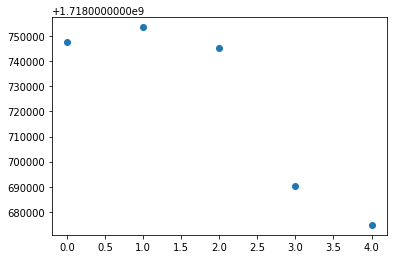

In [27]:
last_acesseds = [m["last_acessed"] for m in memories]

plt.plot(last_acesseds, "o")

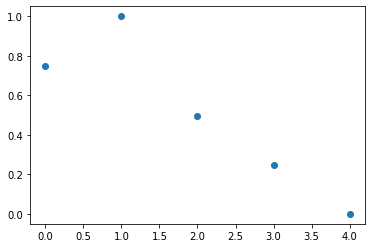

In [28]:
plt.plot(recency["scores"], "o")
plt.show()

## Codelets

In [59]:
from collections import deque

class EmbedderCodelet(cst.Codelet):
    def __init__(self, embedder_model:str|None=None) -> None:
        super().__init__()

        self._embedder = Embedder(embedder_model)
        self._last_process = 0

    def access_memory_objects(self) -> None:
        self._to_process_mo : cst.MemoryObject = self.get_input(name="MemoriesToEmbed")
        self._to_score_mo : cst.MemoryObject = self.get_output(name="MemoriesToScore")

    def calculate_activation(self) -> None:
        pass

    def proc(self) -> None:
        memories_to_embbed : deque = self._to_process_mo.get_info()
        n = len(memories_to_embbed)

        if n == 0:
            return

        memories = []
        for _ in range(n):
            memory = memories_to_embbed.popleft()
            memories.append(memory)

        descriptions = [m['description'] for m in memories]
        query = {"texts":descriptions}
        result, _ = embedder(query)
        embeddings = result["embeddings"]
        
        to_score_queue : deque = self._to_score_mo.get_info()
        for i in range(n):
            memories[i]["embedding"] = embeddings[i]
            to_score_queue.append(memories[i])

        #Just to update timestamp
        self._to_score_mo.set_info(to_score_queue)
        

In [60]:
class ImportanceScorerCodelet(cst.Codelet):
    def __init__(self, model_name:str|None=None) -> None:
        super().__init__()

        self._importance_scorer = MemoryImportanceScorer(model_name)
    
    def access_memory_objects(self) -> None:
        self._to_score_mo = self.get_input(name="MemoriesToScore")
        self._memory_stream_mo = self.get_output(name="MemoryStream")

    def calculate_activation(self) -> None:
        pass

    def proc(self) -> None:
        memories_to_score : deque = self._to_score_mo.get_info()
        memory_stream : List = self._memory_stream_mo.get_info()
        n = len(memories_to_score)

        for _ in range(n):
            memory = memories_to_score.popleft()
            query = {"memory":memory["description"]}
            result, _ = self._importance_scorer(query)
            memory["importance"] = result["score"]

            memory_stream.append(memory)

        #Just to update timestamp
        self._memory_stream_mo.set_info(memory_stream)


In [137]:
class RetrievalCodelet(cst.Codelet):
    def __init__(self, 
                 query_memory_mo:cst.MemoryObject, 
                 retrieved_memories_mo:cst.MemoryObject, 
                 n_to_retrieve:int=100,
                 decay_factor:float|None=None, embedder_model:str|None = None) -> None:
        super().__init__()
        self.add_input(query_memory_mo)
        self.add_output(retrieved_memories_mo)

        self._query_memory_name = query_memory_mo.get_name()
        self._retrieved_memories_name = retrieved_memories_mo.get_name()

        self._n = n_to_retrieve
        self._last_process = 0

        self._recency_scorer = MemoryRelativeRecencyScorer(decay_factor)
        self._relevance_scorer = MemoryRelevanceScorer(embedder_model)

    def access_memory_objects(self) -> None:
        self._query_memory_mo = self.get_input(name=self._query_memory_name)
        self._memory_stream_mo = self.get_input(name="MemoryStream")
        self._retrieved_memories_mo = self.get_output(name=self._retrieved_memories_name)

    def calculate_activation(self) -> None:
        pass

    def proc(self) -> None:
        query_memory = self._query_memory_mo.get_info()
        
        if query_memory is None or query_memory == "":
            return
        if self._query_memory_mo.get_timestamp() <= self._last_process:
            return

        memory_stream : List = self._memory_stream_mo.get_info()
        
        importances = []
        timestamps = []
        embeddings = []

        for memory in memory_stream:
            importances.append(memory["importance"])
            timestamps.append(memory["last_acessed"])
            embeddings.append(memory["embedding"])

        importances = np.array(importances)

        query = {"timestamps":timestamps}
        result, _ = self._recency_scorer(query)
        recencies = result["scores"]

        query = {"query_memory":query_memory["description"], "embeddings":embeddings}
        result, _ = self._relevance_scorer(query)
        relevances = result["scores"]

        scores = importances + recencies + relevances
        indexes = np.argpartition(scores, -self._n)[-self._n:]
        
        retrieved_memories = [memory_stream[i] for i in indexes]

        self._retrieved_memories_mo.set_info(retrieved_memories)


In [138]:
mind = cst.Mind()

memories_input = mind.create_memory_object("MemoriesToEmbed", deque())
memories_to_score = mind.create_memory_object("MemoriesToScore", deque())
memory_stream = mind.create_memory_object("MemoryStream", [])
query_memory = mind.create_memory_object("QueryMemory")
retrieved_memories = mind.create_memory_object("RetrievedMemories")

embedder_codelet = EmbedderCodelet()
embedder_codelet.add_input(memories_input)
embedder_codelet.add_output(memories_to_score)

scorer_codelet = ImportanceScorerCodelet()
scorer_codelet.add_input(memories_to_score)
scorer_codelet.add_output(memory_stream)

retrieval_codelet = RetrievalCodelet(query_memory, retrieved_memories, n_to_retrieve=2)
#retrieval_codelet.add_input(query_memory)
retrieval_codelet.add_input(memory_stream)
#retrieval_codelet.add_output(retrieved_memories)

mind.insert_codelet(embedder_codelet)
mind.insert_codelet(scorer_codelet)
mind.insert_codelet(retrieval_codelet)

for codelet in mind.code_rack.all_codelets:
    codelet.time_step = 100

mind.start()

In [139]:
memory_stream.get_info()

[]

In [140]:
memories_input_queue : deque = memories_input.get_info()
for memory in input_memories:
    memories_input_queue.append(memory)

In [141]:
import time
time.sleep(2)

len(memory_stream.get_info()), memory_stream.get_info()[0]["importance"], "embedding" in memory_stream.get_info()[0]

(5, 0.3888888888888889, True)

In [142]:
retrieved_memories.get_info()

''

In [143]:
query = {"description":"What did Alex think about after attending the photography workshop?"}

query_memory.set_info(query)

-1

In [147]:
time.sleep(200/1000)
[m["description"] for m in retrieved_memories.get_info()]

['After delivering the project, Alex felt a sense of relief and accomplishment, thinking about the challenges overcome.',
 'Alex went on a weekend trip to explore a national park, taking photos of the wildlife and landscapes.']

In [145]:
mind.shutdown()